## Загрузка библиотек

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats

## Загрузка данных

### Задание 1 (0.5 балла)

Для начала работы нам необходимо научиться читать набор данных. В данном домашнем задании мы поработаем с двумя наборами данных.

__covid.csv__ ([источник](https://www.kaggle.com/gpreda/covid-world-vaccination-progress)) - статистика по вакцинированию от COVID19 по разным странам. Для данного датасета нет конкретной предсказательной переменной.

__hr.csv__ ([источник](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists)) - набор данных большего размера. Он содержит статистику по людям, проходящим курсы по Big Data & ML. _Target_ - 1 или 0, сменил ли человек работу после прохождения курсов - или нет.

Реализуйте методы `read_covid_dataset` и `read_hr_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. В случае _covid_ датасета `y` возвращается как `None`. 

In [15]:
def read_covid_dataset(path_to_csv):
    df = pd.read_table(path_to_csv, sep=',')
    X = df.values
    y = None
    return X, y


def read_hr_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pd.read_table(path_to_csv, sep=',')
    X = df.values[:, :-1]
    y = df.values[:, -1]
    return X, y

In [8]:
COVID_DATA_PATH = "covid.csv"
HR_DATA_PATH = "hr.csv"

In [68]:
X_covid, _ = read_covid_dataset(COVID_DATA_PATH)
X_hr, y_hr = read_hr_dataset(HR_DATA_PATH)

## EDA

### Задание 2 (3.5 балла)

Выполните задание для датасетa _hr_.

Для дальнейшей работы с данными нужно обработать пропущенные значения в датасете.
Существуют различные стратегии обработки пропущенных данных.

#### 1. (0.5 балла)

Для числовых признаков постройте распределения признаков. Для категориальных признаков выведите статистику по количеству значений признака.

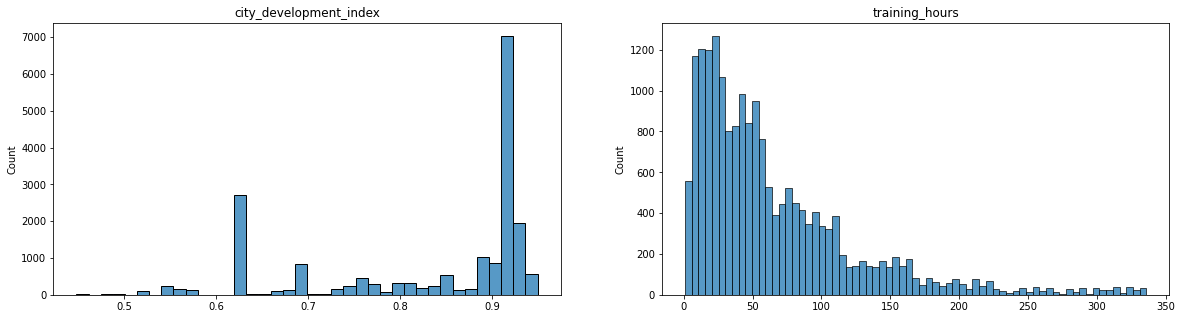

         city
      city     count
  city_103      4355
   city_21      2702
   city_16      1533
  city_114      1336
  city_160       845
       ...       ...
  city_129         3
  city_121         3
  city_111         3
  city_171         1
  city_140         1
____________________


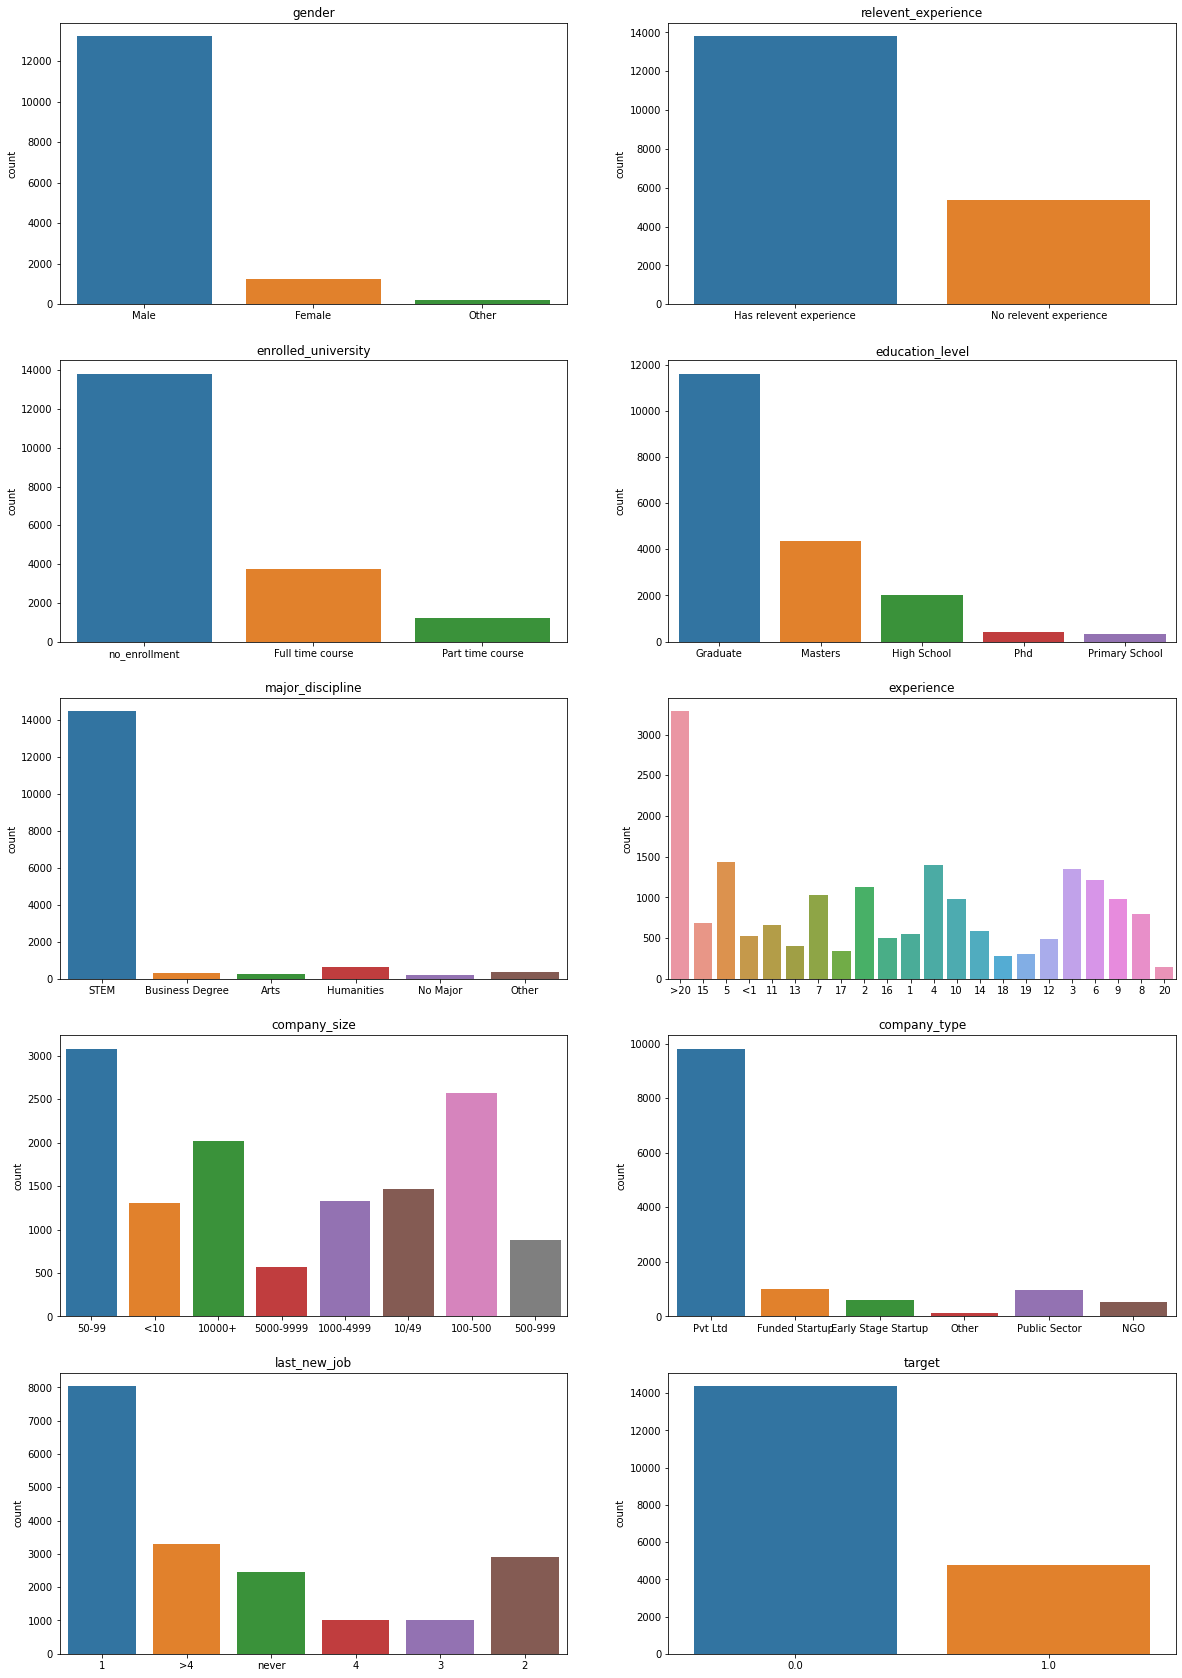

In [181]:
def drawPlots(X, y):
    #распределение чиcловых признаков
    plt.figure(figsize = (20, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(X[:, 2])
    plt.title("city_development_index")
    
    plt.subplot(1, 2, 2)
    sns.histplot(X[:, -1])
    plt.title("training_hours")
    plt.show()
    
    #статистика категориальных признаков:
    
    #city (плохо визуализируется, так как очень много значений)
    values, counts = np.unique(X[:, 1], return_counts=True)
    listOfCities = []
    
    for i in range(len(values)):
        listOfCities.append((values[i], counts[i]))
    
    listOfCities.sort(key = lambda x : x[1])
    
    print("city".rjust(13))
    print("city".rjust(10), "count".rjust(10), sep = '')
    for i in range(-1, -6, -1):
        print(listOfCities[i][0].rjust(10), str(listOfCities[i][1]).rjust(10), sep = '')
    print("...".rjust(10), "...".rjust(10), sep = '')
    for i in range(4, -1, -1):
        print(listOfCities[i][0].rjust(10), str(listOfCities[i][1]).rjust(10), sep = '')
    print("_" * 20)
    
    #хорошо визуализируемые признаки
    names = ["gender", "relevent_experience", "enrolled_university", "education_level", "major_discipline", \
             "experience", "company_size", "company_type", "last_new_job","target"]
    
    plt.figure(figsize = (20, 30))
    
    for i in range(1, 10):
        plt.subplot(5, 2, i)
        sns.countplot(x = X[:, i + 2])
        plt.title(names[i-1])
    
    plt.subplot(5, 2, 10)
    sns.countplot(x = y)
    plt.title(names[-1])
               
    plt.show()

drawPlots(X_hr, y_hr)

#### 2. (0.5 балла)
Удалите все строки, где есть хотя бы одно пропущенное значение признака. Насколько сильно уменьшился размер датасета? Как изменились распределения признаков/статистика по количеству значений признаков?

In [167]:
print(f'Исходный размер датасета hr: {len(X_hr)}')

Исходный размер датасета hr: 19158


In [168]:
Y = []
for i in X_hr:
    for j in i:
        if j is np.nan:
            Y.append(False)
            break
    else:
        Y.append(True)

X_hr_dropna = X_hr[Y]
y_hr_dropna = y_hr[Y]

In [169]:
print(f'Pазмер датасета hr без NaN: {len(X_hr_dropna)}')

Pазмер датасета hr без NaN: 8955


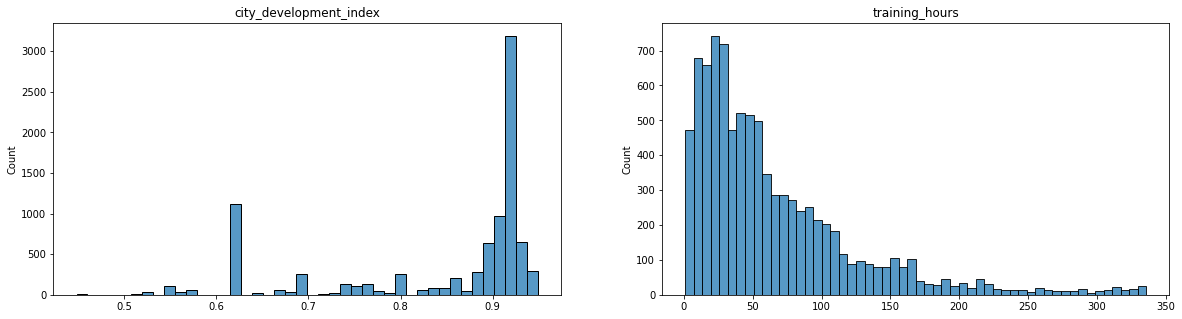

         city
      city     count
  city_103      2426
   city_21      1111
   city_16       836
  city_114       648
  city_160       401
       ...       ...
  city_129         1
  city_127         1
  city_121         1
  city_109         1
  city_107         1
____________________


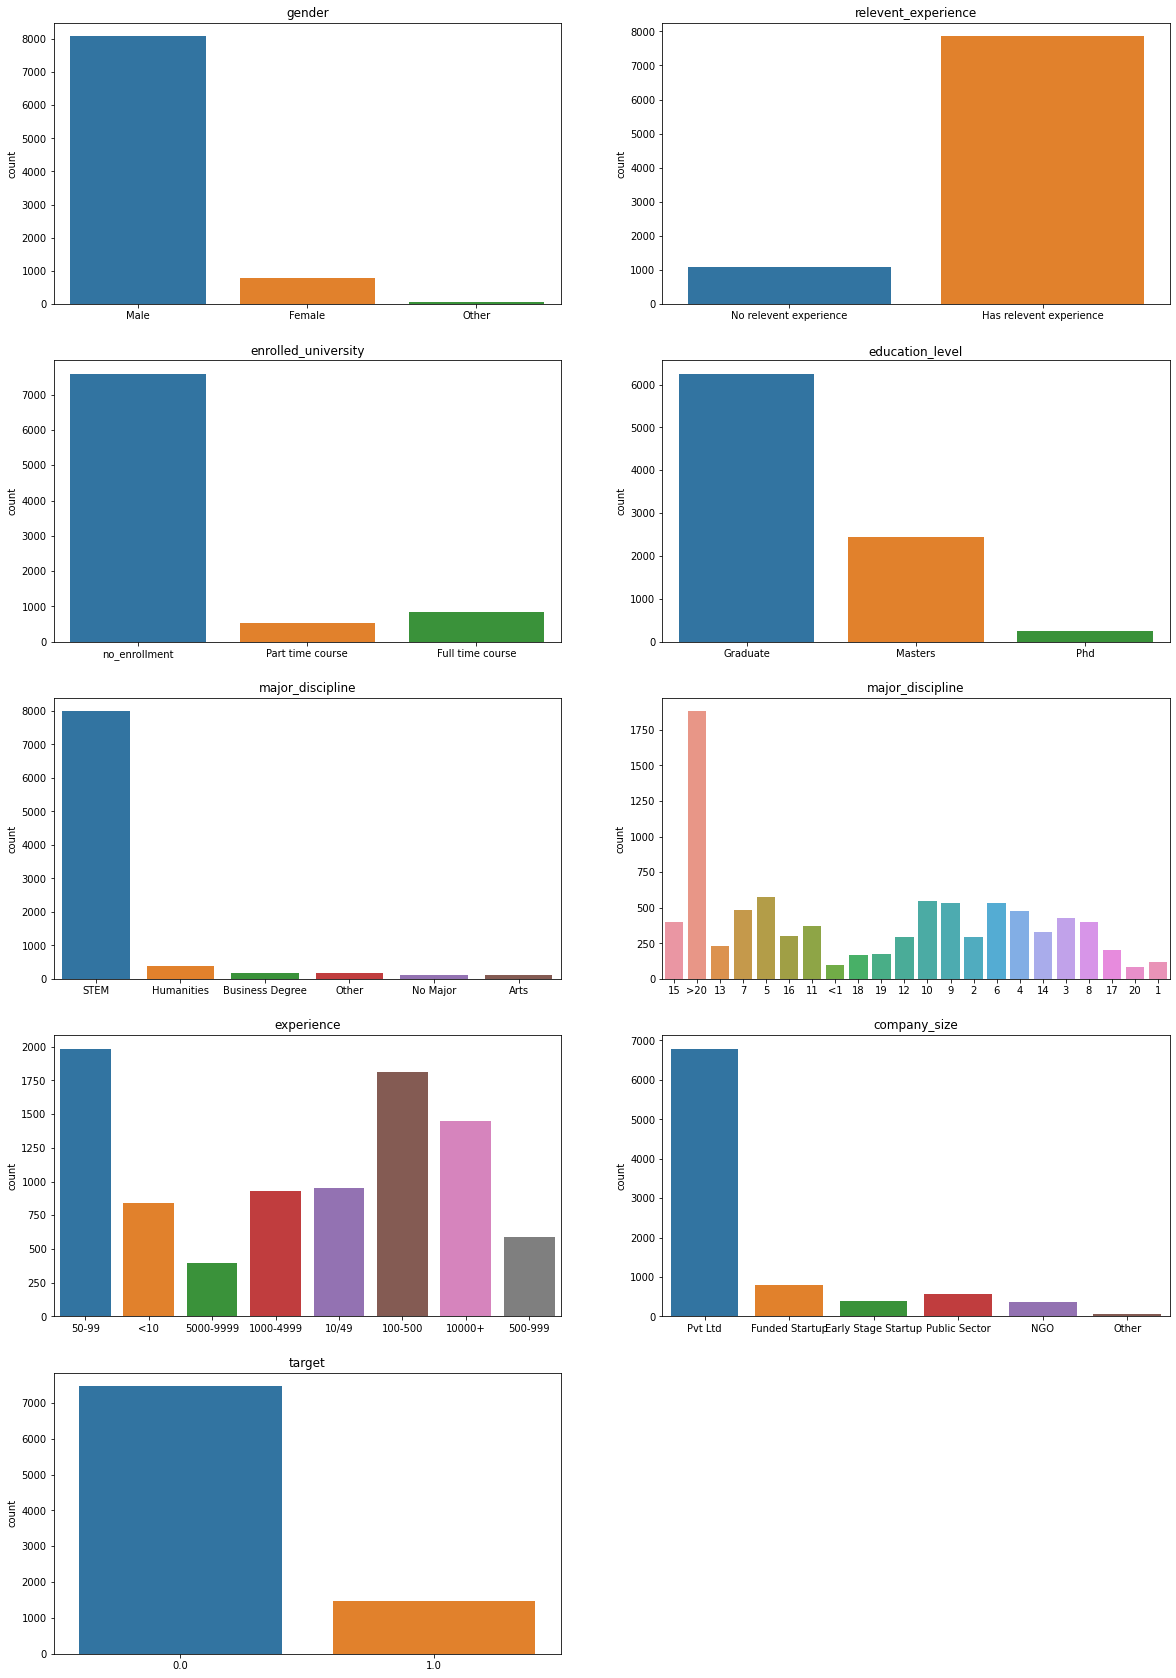

In [170]:
#распределение признаков после удаления NaN
drawPlots(X_hr_dropna, y_hr_dropna)

_Ваш ответ_

**Размер датасета уменьшился примерно в два раза. Мажорирующие значения не изменились, но стало значительно меньше людей без опыта, ранее не работавших и проч. Особенно сильно пострадало разнообразие значений в колонке edication_level — полностью исчезли значения "High School" и "Primary School".**

Давайте попробуем избежать сокращения размера датасета.

#### 3.  (1 балл)
Для числовых признаков заполните пропущенные данные средним/медианой/модой данного признака. Объясните свой выбор. (Часть строк с NaN значениями можно удалить, если размер датасета уменьшится <15%)

__Поскольку точное медианное значение может приниматься в редких случаях, а среднее значение может вовсе отсутствовать в выборке, то их использование может повлиять на распределение значений. Поэтому при ярко выраженной моде лучше заполнять данные именно ей.__ 

__В случае же редкой повторяемости данных — например, при вычислении различных дробных характеристик, имеет смысл использовать медиану, так как она более устойчива к выбросам, чем среднее значение.__

#### 4.  (1 балл)
Для категориальных признаков заполните пропущенные значения самой встречающейся категорией или создайте отдельную категорию пропущенных значений. Объясните свой выбор. (Часть строк с NaN значениями можно удалить, если размер датасета уменьшится <15%)

_Ваш ответ_

__Поскольку при удалении NaN в датасете сильно уменьшилось количество людей без опыта работы, то пропуски в признаках, связанных с местом работы или образованием вполне могут означать отсутствие подходящего варианта категории при изначальном сборе данных, поэтому для таких признаков имеет смысл ввести отдельную категорию пропущенных значений.__

__В остальных случаях будем заполнять значение самой популярной категорией.__

In [185]:
#Найдем в каких признаках встречаются пропуски
Z = [False] * 13
for i in X_hr:
    for j in range(len(i)):
        if i[j] is np.nan:
            Z[j] = True
print(Z)

[False, False, False, True, False, True, True, True, True, True, True, True, False]


In [192]:
#Подготовим словарь замен
dictForFilling = dict()

dictForFilling[3] = stats.mode(X_hr[:, 3])[0][0] # gender
dictForFilling[5] = "SKIPPED" # enrolled_university
dictForFilling[6] = "SKIPPED" # education_level
dictForFilling[7] = "SKIPPED" # major_discipline
dictForFilling[8] = "SKIPPED" # experience
dictForFilling[9] = "SKIPPED" # company_size
dictForFilling[10] = "SKIPPED" # company_type
dictForFilling[11] = "SKIPPED" # last_new_job
dictForFilling['y'] = stats.mode(y_hr)[0][0] # target


In [197]:
def fill_na(X, y):
    
    X_fill = np.copy(X)
    y_fill = np.copy(y)
    
    for i in range(len(X_fill)):
        for j in range(len(X_fill[0])):
            if X_fill[i][j] is np.nan:
                X_fill[i][j] = dictForFilling[j]
    for i in range(len(y_fill)):
        if y_fill[i] is np.nan:
            y_fill[i] = dictForFilling['y']
    
    return X_fill, y_fill

In [201]:
X_hr_fill, y_hr_fill = fill_na(X_hr, y_hr)

#### 5.  (0.5 балла)
Как изменились распределения признаков/статистика по количеству значений признаков после заполнения пропущенных данных?

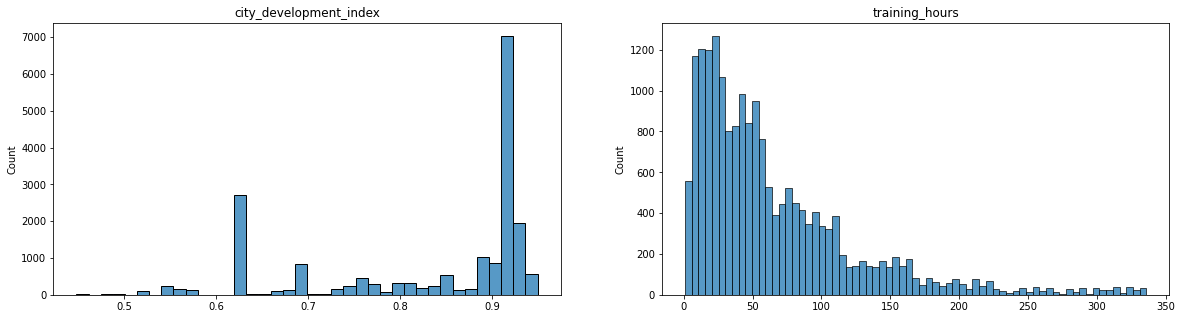

         city
      city     count
  city_103      4355
   city_21      2702
   city_16      1533
  city_114      1336
  city_160       845
       ...       ...
  city_129         3
  city_121         3
  city_111         3
  city_171         1
  city_140         1
____________________


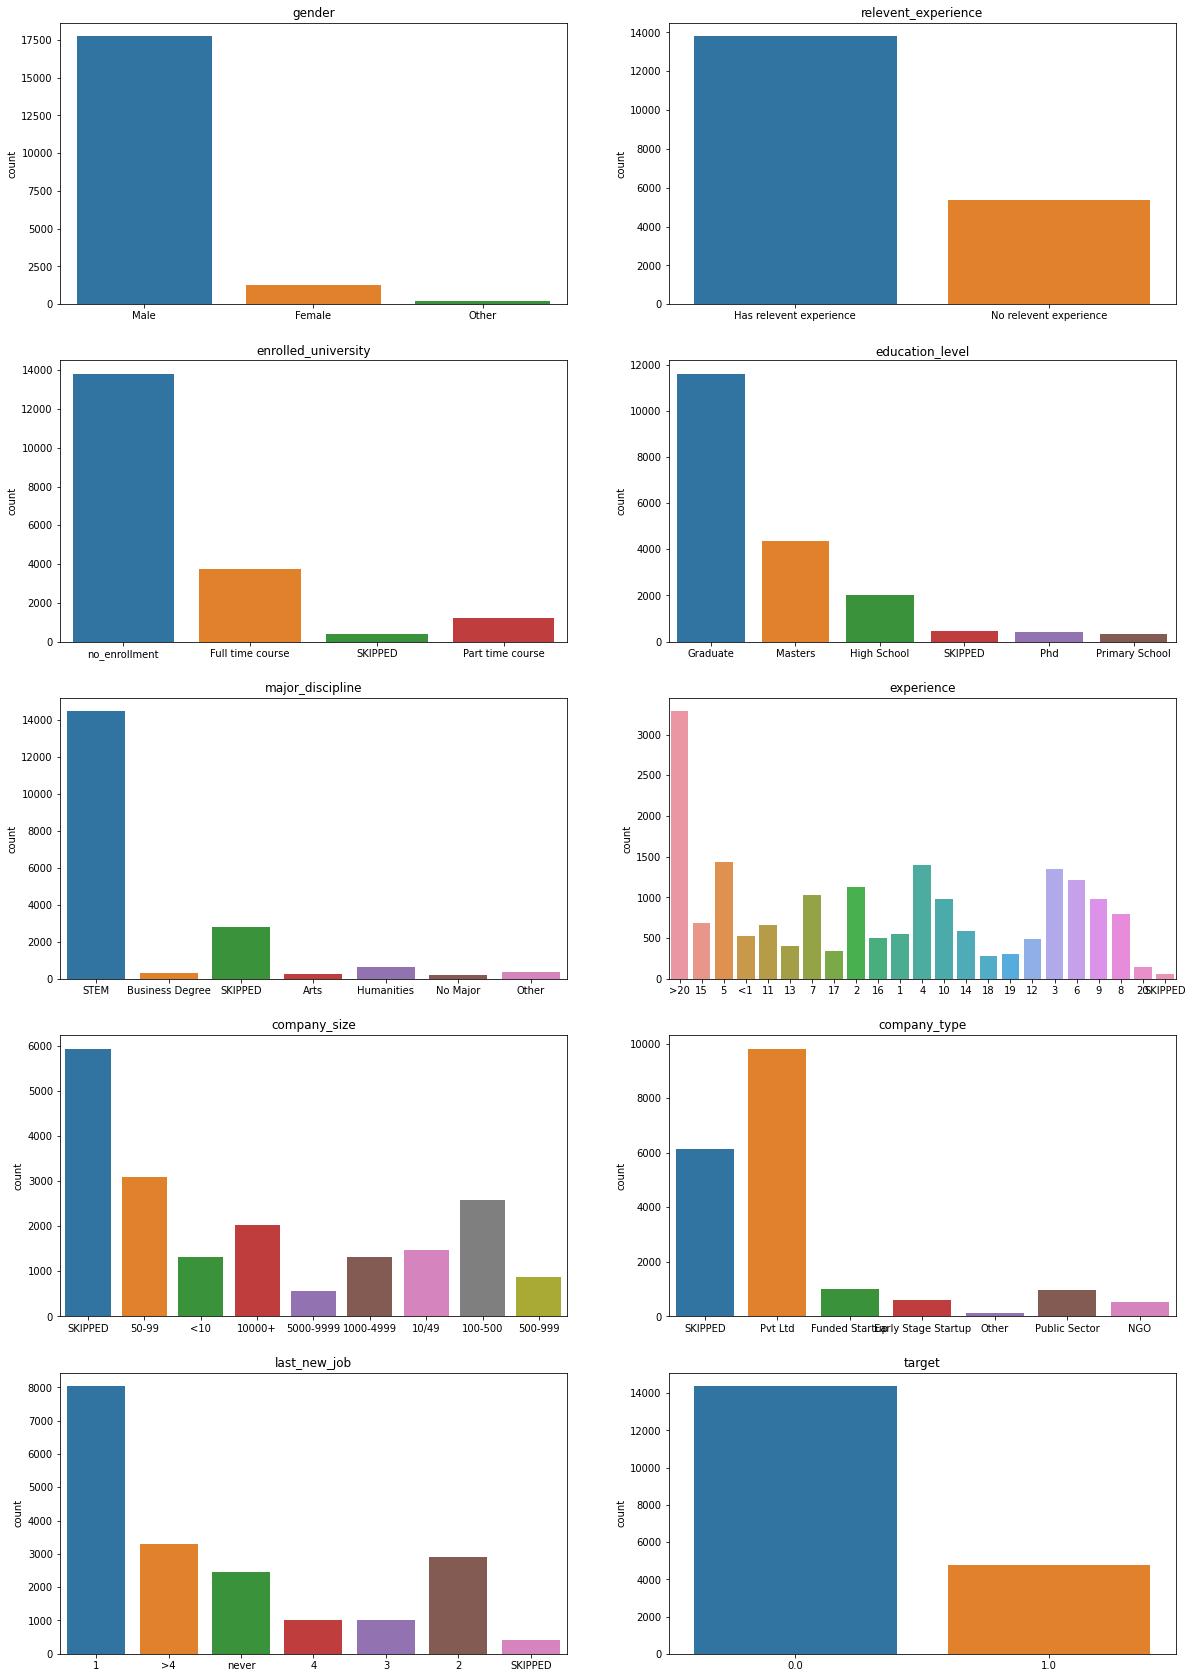

In [202]:
#распределение признаков после удаления NaN
drawPlots(X_hr_fill, y_hr_fill)

_Ваш ответ_

__Для полей признаков 'company_type' и 'company_size' новая категория (SKIPPED) занимает значительный процент датасета, поэтому можно считать Её введение оправданным. Для остальных признаков незаполненений совсем мало, поэтому соответствующие строки датасета вполне можно было удалить.__

### Задание 3  (1 балл)

Выполните задание для датасета _covid_.

1. Найдите страну, для которой в датасете присутствует 46 дат со статистикой по вакцинации.
2. Постройте для этой страны график зависимости _total_vaccinations_ от _date_.
3. Заполните пропущенные данные о _total_vaccinations_ для этой страны. Объясните свой выбор.

_Ваш ответ_

### Задание  4 (0.5 балла)
Выполните задание для датасета _hr_.

Есть ли в данных выбросы? Если да, то скажите, какие и почему Вы считаете их выбросами?


In [46]:
# YOUR_CODE

_Ваш ответ_

### Задание  5 (1 балл)
Выполните задание для датасета _hr_.

Закодируйте категориальные признаки при помощи One-hot encoding/Label encoding/Frequency encoding. Объясните свой выбор. (Обратите внимание, что некоторые категориальные признаки предполагают ранжирование в своих значениях)


In [ ]:
def encode(X):
    # Возвращает данные без категориальных признаков
    return X_encode

In [ ]:
X_hr_encode = encode(X_hr_fill)

_Ваш ответ_

### Задание  5 (1 балл)
Выполните задание для датасета _hr_.




#### 1.  (1 балл)
Реализуйте функцию undersampling

#### 2.  (1 балл)
Реализуйте функцию oversampling

In [ ]:
def undersampling(X, y):
    # Возвращает данные, сбалансированные методом undersampling
    return X_under, y_under

def oversampling(X, y):
    # Возвращает данные, сбалансированные методом undersampling
    return X_over, y_over

In [ ]:
X_hr_under, y_hr_under = undersampling(X_hr_encode, y_hr_fill)

X_hr_over, y_hr_over = oversampling(X_hr_encode, y_hr_fill)

#### 3.  (1 балл)
Используйте _SMOTE_ для балансировки датасета.

Помимо методов _undersampling_ и _oversampling_ существует подход, генерирующий элементы класса-меньшинства, похожие на уже присутствующие в выборке данных. Такой метод называется _Synthetic Minority Oversampling Technique_ (SMOTE). 

Метод _SMOTE_ , реализованный в библиотеке `imblearn`, генерирует синтетические примеры при помощи __k-nearest neighbor__ алгоритма (подробнее об этом алгоритме будет рассказано на лекции).

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

smote = # YOUR_CODE
X_hr_SMOTE, y_hr_SMOTE = # YOUR_CODE

#### 4. (0.5 балла)
Как изменились распределения признаков при различных тактиках балансирования датасета?

In [92]:
# YOUR CODE

_Ваш ответ_